# Wines Points prediction 

Submission Date : 3.6.2023
Task: Predict the wine score given the inputs
Instructions:
 * Use logistic regression as benchmark model
 * Use sklearn pipeliens + cv + grid search with sklearn models (e.g. KNNs, RandomForest, etc.)
 * Compare all models on proper metric (your choice)

For DNN course project:
* Use sklearn pipeliens with tensorflow models (w/wo embeddings, LSTMs, RNNs, Transformers etc.)
* Compare all models on proper metric (your choice)

In [2]:
import nltk
import sys; sys.path.append('../')

In [3]:
import string
import emoji
import re as regex
from pandas import * 

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn import set_config
import pandas as pd
import cufflinks as cf; cf.go_offline()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

# Try categorical and numeric columns only preprocessing

In [5]:
wine_reviews = pd.read_csv("data/wine_reviews.csv", index_col=0)
wine_reviews.shape

(119924, 8)

In [6]:
reviews = wine_reviews
reviews.sample(5)

,country,description,points,price,province,taster_name,variety,year
22163,France,Pure notes of Conference pear define both nose...,91,20.0,Alsace,Anne Krebiehl MW,Pinot Gris,2015.0
91257,Chile,"Angular and piquant on the nose, with tight ar...",86,24.0,Leyda Valley,Michael Schachner,Pinot Noir,2007.0
39569,US,"In 2011, the fifth vintage of this Riesling, t...",88,13.0,Washington,Paul Gregutt,Riesling,2011.0
120064,US,"Dusty, earthy mineral tones blow off to reveal...",89,25.0,New York,Anna Lee C. Iijima,Riesling,2013.0
123401,US,Bright black cherry animates the aromas and fl...,88,24.0,California,Jim Gordon,Syrah,2013.0


In [7]:
#veriety
print(wine_reviews.variety.value_counts().shape)
veriety_count = wine_reviews.variety.value_counts().sort_values(ascending=False)
veriety_count_sum = veriety_count.sum()
#print(veriety_count.head(50))
veriety_count.head(100).sum()/veriety_count_sum

(701,)


0.9474000200126746

In [8]:
#province
print(wine_reviews.province.value_counts().shape)
province_count = wine_reviews.province.value_counts().sort_values(ascending=False)
province_count_sum = province_count.sum()
#print(province_count.head(50))
province_count.head(50).sum()/province_count_sum

(425,)


0.9114105600213469

In [9]:
reviews.year[wine_reviews.year.isna()] = 1800
reviews.sample(5)
reviews[reviews.year.isna()]

,country,description,points,price,province,taster_name,variety,year


In [10]:
x_train = reviews.drop(columns={'description', 'points'})
y_train = reviews['points']
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
X_train.shape

(95939, 6)

In [11]:
X_train.columns

Index(['country', 'price', 'province', 'taster_name', 'variety', 'year'], dtype='object')

In [12]:
categorical_features = ['country','province','taster_name', 'variety']
numerical_features = ['price', 'year']

# Create categorical and numerical transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine transformers using ColumnTransformer
wine_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
],  remainder="passthrough",
    verbose_feature_names_out=False)

In [13]:
set_config(transform_output='pandas')
wine_data =  wine_preprocessor.fit_transform(X_train)

In [14]:
print(wine_data.shape)
wine_data.sample(5)

(95939, 1148)


,price,year,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,country_Canada,...,variety_Xynisteri,variety_Yapincak,variety_Zelen,variety_Zibibbo,variety_Zierfandler,variety_Zierfandler-Rotgipfler,variety_Zinfandel,variety_Zlahtina,variety_Zweigelt,variety_Çalkarası
49628,-0.530756,0.076002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32046,-0.241116,0.279856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7924,-0.023887,0.177929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53083,0.579529,0.101484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65810,0.000250,0.228893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
from sklearn.linear_model import Ridge

In [16]:
# Create a full pipeline with a classifier
full_pipeline = Pipeline(steps=[
    ('preprocessor', wine_preprocessor),
    ('classifier', Ridge(alpha=10))
])

# Fit the pipeline to the training data
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price', 'year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country', 'province',
                                                   'taster_name', 'variety'])],
                                   verbose_feature_names_out=False)),
                ('classifier', Ridge(alpha=10))])

In [20]:
categorical_pipeline = Pipeline(steps=[
    ('preprocessor', wine_preprocessor),
    ('param_reduction', PCA()),
    ('classifier', Ridge()),
    
])

param_grid = [
    {        
        'param_reduction__n_components': [100, 300, None],
        'classifier__alpha': [0.1, 1, 10, 100],
    }
]

In [21]:
from sklearn.model_selection import GridSearchCV
categorical_pipeline_grid_search = GridSearchCV(categorical_pipeline, param_grid = param_grid, cv=3, scoring='r2', verbose=5)
categorical_pipeline_grid_search

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['price',
                                                                          'year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['country',
                                                                          'province',
                                                                          'taster_name',
                                                                          'variety'])],
                                                          verbose_feature_names_out=False)),
                                       ('param_reduction', PCA()),
                                       ('classifier', Ridge())]),
             param_grid=[{'classifier__alpha': [0.1, 1, 10, 100],
                          'param_reduction__n_components': [100, 300, None]}],
             scoring='r2', verbose=5)

In [22]:
categorical_pipeline_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END classifier__alpha=0.1, param_reduction__n_components=100;, score=0.274 total time=   9.8s
[CV 2/3] END classifier__alpha=0.1, param_reduction__n_components=100;, score=0.272 total time=  10.3s
[CV 3/3] END classifier__alpha=0.1, param_reduction__n_components=100;, score=0.289 total time=  10.9s
[CV 1/3] END classifier__alpha=0.1, param_reduction__n_components=300;, score=0.289 total time=  20.3s
[CV 2/3] END classifier__alpha=0.1, param_reduction__n_components=300;, score=0.287 total time=  17.2s
[CV 3/3] END classifier__alpha=0.1, param_reduction__n_components=300;, score=0.305 total time=  17.9s
[CV 1/3] END classifier__alpha=0.1, param_reduction__n_components=None;, score=0.290 total time=  23.4s
[CV 2/3] END classifier__alpha=0.1, param_reduction__n_components=None;, score=0.288 total time=  22.2s
[CV 3/3] END classifier__alpha=0.1, param_reduction__n_components=None;, score=0.305 total time=  23.7s
[CV 1/3] 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['price',
                                                                          'year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['country',
                                                                          'province',
                                                                          'taster_name',
                                                                          'variety'])],
                                                          verbose_feature_names_out=False)),
                                       ('param_reduction', PCA()),
                                       ('classifier', Ridge())]),
             param_grid=[{'classifier__alpha': [0.1, 1, 10, 100],
                          'param_reduction__n_components': [100, 300, None]}],
             scoring='r2', verbose=5)

In [23]:
cols = [ 'param_param_reduction__n_components', 'param_classifier__alpha','std_test_score', 'rank_test_score', 'mean_test_score']
cv_results_df = pd.DataFrame(categorical_pipeline_grid_search.cv_results_)
cv_results_df.sort_values(by = 'mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_param_reduction__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,20.586340,0.534888,2.408767,0.058834,10,None,"{'classifier__alpha': 10, 'param_reduction__n_...",0.292302,0.289904,0.308388,0.296864,0.008207,1
5,20.715596,0.163304,2.409735,0.104359,1,None,"{'classifier__alpha': 1, 'param_reduction__n_c...",0.291946,0.289761,0.307855,0.296521,0.008064,2
2,20.825722,0.598614,2.349758,0.059035,0.1,None,"{'classifier__alpha': 0.1, 'param_reduction__n...",0.290275,0.287917,0.305466,0.294553,0.007777,3
1,17.337073,1.364923,1.230909,0.029918,0.1,300,"{'classifier__alpha': 0.1, 'param_reduction__n...",0.289431,0.286709,0.304819,0.293653,0.007973,4
7,15.993500,0.172246,1.353650,0.117823,10,300,"{'classifier__alpha': 10, 'param_reduction__n_...",0.289162,0.286848,0.304946,0.293652,0.008042,5
4,16.340913,0.244385,1.228187,0.066834,1,300,"{'classifier__alpha': 1, 'param_reduction__n_c...",0.289666,0.286144,0.304748,0.293520,0.008069,6
11,20.708218,0.255191,2.419448,0.097822,100,None,"{'classifier__alpha': 100, 'param_reduction__n...",0.284503,0.282049,0.300599,0.289050,0.008227,7
10,16.028100,0.217657,1.202840,0.095923,100,300,"{'classifier__alpha': 100, 'param_reduction__n...",0.283762,0.281252,0.299769,0.288261,0.008202,8
0,9.498365,0.359774,0.917455,0.088510,0.1,100,"{'classifier__alpha': 0.1, 'param_reduction__n...",0.273611,0.271595,0.289162,0.278123,0.007850,9
3,9.353379,0.047461,0.970651,0.048352,1,100,"{'classifier__alpha': 1, 'param_reduction__n_c...",0.273763,0.271204,0.288911,0.277959,0.007814,10


In [24]:
y_predicted = categorical_pipeline_grid_search.predict(X_test)
y_train_predicted = categorical_pipeline_grid_search.predict(X_train)

In [25]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_predicted))
# The coefficient of determination: 1 is perfect prediction
print("R2: %.2f" % r2_score(y_test, y_predicted))
predicted_df1 = DataFrame()
predicted_df1["actual"] = y_test
predicted_df1["predicted"] = y_predicted
predicted_df1["price"] = X_test.price
predicted_df1["error"] = abs(y_test - y_predicted)
predicted_df1.sort_values(by="error", ascending=False).head(10)

Mean squared error: 6.69
R2: 0.30


,actual,predicted,price,error
113564,96,137.127361,2000.0,41.127361
1575,96,119.635868,1300.0,23.635868
1571,96,117.200577,1200.0,21.200577
88870,94,111.097728,900.0,17.097728
43655,95,108.257407,775.0,13.257407
43650,95,108.250031,775.0,13.250031
56959,96,108.453523,820.0,12.453523
347,97,108.264783,775.0,11.264783
118059,99,87.863746,44.0,11.136254
116094,99,88.585912,NaN,10.414088


In [176]:
results_df = DataFrame(columns=['name','classifier','alpha','reduction','train_r2','train_mse', 'test_r2', 'test_mse'])

def append_to_results(name, classifier, alpha, reduction, y_test, y_predict, y_train, y_train_predicted):
    test_r2 = r2_score(y_test, y_predicted), 
    test_mse = mean_squared_error(y_test, y_predicted)
    train_r2 = r2_score(y_train, y_train_predicted)
    train_mse = mean_squared_error(y_train, y_train_predicted)
    
    return results_df.append({'name':name, 'classifier':classifier, 'alpha': alpha, 'reduction':reduction, 'test_r2': test_r2, 'test_mse':test_mse, 'train_r2': train_r2, "train_mse": train_mse}, ignore_index=True)

def append_row_to_results(name, classifier, alpha, reduction, test_r2, test_mse, train_r2, train_mse):
    return results_df.append({'name':name, 'classifier':classifier, 'alpha': alpha, 'reduction':reduction, 'test_r2': test_r2, 'test_mse':test_mse, 'train_r2': train_r2, "train_mse": train_mse}, ignore_index=True)
    

In [27]:
categorical_pipeline_grid_search.best_params_

{'classifier__alpha': 10, 'param_reduction__n_components': None}

In [28]:
results_df = append_to_results("all categories and price",'Ridge', '10', 'None', y_test, y_predicted, y_train, y_train_predicted)

C:\Users\olgas\AppData\Local\Temp\ipykernel_19968\16745098.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [29]:
results_df

,name,classifier,alpha,reduction,train_r2,train_mse,test_r2,test_mse
0,all categories and price,Ridge,10,None,0.305234,6.64789,"(0.30081382552241454,)",6.688209


                                index         w
0                  province_Andalucia  2.104901
1        taster_name_Anne Krebiehl MW  2.057815
2                 province_California  2.028812
3                province_Puente Alto  1.924628
4               variety_Petit Manseng  1.898676
5                      province_Peumo  1.776085
6           taster_name_Mike DeSimone  1.735011
7                      variety_Sherry  1.730872
8                  province_Champagne  1.717619
9               variety_Tinta de Toro  1.714328
10                province_Washington  1.679139
11                 variety_Sagrantino  1.596040
12            variety_Tannat-Cabernet  1.574525
13                      country_Italy  1.567648
14      variety_Tannat-Cabernet Franc  1.560889
15                 variety_Tinto Fino  1.547470
16                country_New Zealand  1.510966
17                  variety_Alvarinho  1.496035
18          variety_Sangiovese Grosso  1.469317
19               country_South Africa  1

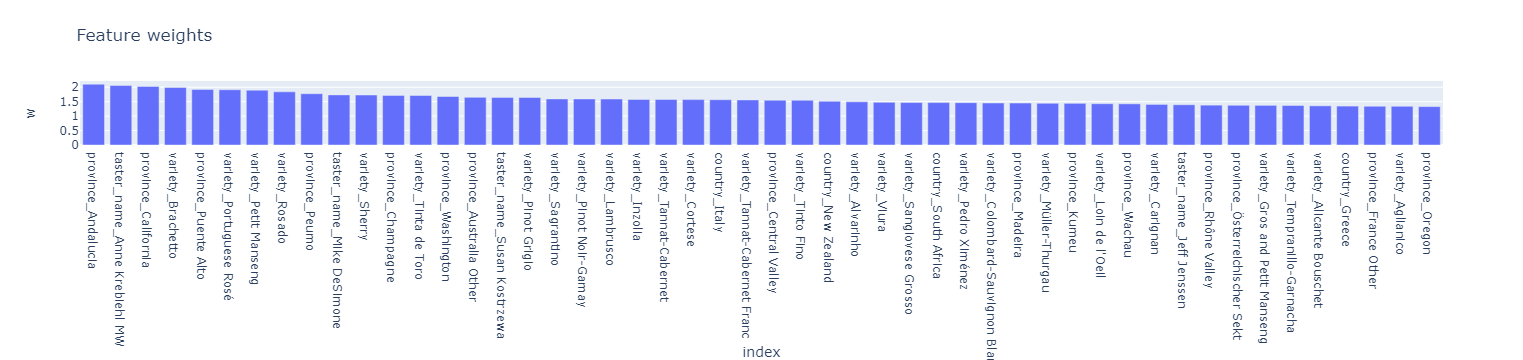

In [30]:
import plotly_express as px
reg = full_pipeline[-1]
coef = pd.Series(reg.coef_.ravel(), index=reg.feature_names_in_).rename('w')
print(coef.sort_values(ascending=False).reset_index().head(50))
px.bar(coef.abs().sort_values(ascending=False).reset_index().head(50), x='index', y='w', title = 'Feature weights')

## Try limit categories to popular categories

In [31]:
reviews2 = reviews
province_to_keep = province_count.head(50).index.array
reviews2.province = reviews2.province.apply(lambda x: x if x in province_to_keep else 'unknown')

veriety_to_keep = veriety_count.head(100).index.array
reviews2.variety = reviews2.variety.apply(lambda x: x if x in veriety_to_keep else 'unknown')

print(reviews.province.value_counts().sort_values(ascending=False).head(5))
print(reviews.variety.value_counts().sort_values(ascending=False).head(5))

California    33656
unknown       10624
Washington     7964
Bordeaux       5554
Tuscany        5391
Name: province, dtype: int64
Pinot Noir                  12275
Chardonnay                  10864
Cabernet Sauvignon           8838
Red Blend                    8233
Bordeaux-style Red Blend     6469
Name: variety, dtype: int64


In [32]:
x_train = reviews2.drop(columns={'description', 'points'})
y_train = reviews2['points']
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
X_train.shape

(95939, 6)

In [33]:
categorical_pipeline_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END classifier__alpha=0.1, param_reduction__n_components=100;, score=0.274 total time=   2.5s
[CV 2/3] END classifier__alpha=0.1, param_reduction__n_components=100;, score=0.272 total time=   2.3s
[CV 3/3] END classifier__alpha=0.1, param_reduction__n_components=100;, score=0.289 total time=   2.4s
[CV 1/3] END classifier__alpha=0.1, param_reduction__n_components=300;, score=nan total time=   0.2s
[CV 2/3] END classifier__alpha=0.1, param_reduction__n_components=300;, score=nan total time=   0.2s
[CV 3/3] END classifier__alpha=0.1, param_reduction__n_components=300;, score=nan total time=   0.2s
[CV 1/3] END classifier__alpha=0.1, param_reduction__n_components=None;, score=0.285 total time=   1.6s
[CV 2/3] END classifier__alpha=0.1, param_reduction__n_components=None;, score=0.283 total time=   1.6s
[CV 3/3] END classifier__alpha=0.1, param_reduction__n_components=None;, score=0.300 total time=   1.6s
[CV 1/3] END cl

C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitte

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['price',
                                                                          'year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['country',
                                                                          'province',
                                                                          'taster_name',
                                                                          'variety'])],
                                                          verbose_feature_names_out=False)),
                                       ('param_reduction', PCA()),
                                       ('classifier', Ridge())]),
             param_grid=[{'classifier__alpha': [0.1, 1, 10, 100],
                          'param_reduction__n_components': [100, 300, None]}],
             scoring='r2', verbose=5)

In [34]:
print(categorical_pipeline_grid_search.best_params_)
y_predicted = categorical_pipeline_grid_search.predict(X_test)
y_train_predicted = categorical_pipeline_grid_search.predict(X_train)


results_df = append_to_results("popular categories and price",'Ridge', '1', 'None', y_test, y_predicted, y_train, y_train_predicted)

{'classifier__alpha': 1, 'param_reduction__n_components': None}


C:\Users\olgas\AppData\Local\Temp\ipykernel_19968\16745098.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [35]:
results_df

,name,classifier,alpha,reduction,train_r2,train_mse,test_r2,test_mse
0,all categories and price,Ridge,10,None,0.305234,6.647890,"(0.30081382552241454,)",6.688209
1,popular categories and price,Ridge,1,None,0.294004,6.755348,"(0.2935037872691477,)",6.758134


## Activate log for the price - remove outliers

In [36]:
reviews3 = reviews

In [37]:
reviews3['price'] = np.log(reviews3['price'])

In [38]:
x_train = reviews3.drop(columns={'description', 'points'})
y_train = reviews3['points']
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
X_train.shape

(95939, 6)

In [39]:
categorical_pipeline_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END classifier__alpha=0.1, param_reduction__n_components=100;, score=0.431 total time=   2.3s
[CV 2/3] END classifier__alpha=0.1, param_reduction__n_components=100;, score=0.430 total time=   2.4s
[CV 3/3] END classifier__alpha=0.1, param_reduction__n_components=100;, score=0.433 total time=   2.3s
[CV 1/3] END classifier__alpha=0.1, param_reduction__n_components=300;, score=nan total time=   0.2s
[CV 2/3] END classifier__alpha=0.1, param_reduction__n_components=300;, score=nan total time=   0.2s
[CV 3/3] END classifier__alpha=0.1, param_reduction__n_components=300;, score=nan total time=   0.3s
[CV 1/3] END classifier__alpha=0.1, param_reduction__n_components=None;, score=0.437 total time=   1.8s
[CV 2/3] END classifier__alpha=0.1, param_reduction__n_components=None;, score=0.435 total time=   1.9s
[CV 3/3] END classifier__alpha=0.1, param_reduction__n_components=None;, score=0.440 total time=   1.7s
[CV 1/3] END cl

C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitte

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['price',
                                                                          'year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['country',
                                                                          'province',
                                                                          'taster_name',
                                                                          'variety'])],
                                                          verbose_feature_names_out=False)),
                                       ('param_reduction', PCA()),
                                       ('classifier', Ridge())]),
             param_grid=[{'classifier__alpha': [0.1, 1, 10, 100],
                          'param_reduction__n_components': [100, 300, None]}],
             scoring='r2', verbose=5)

In [40]:
print(categorical_pipeline_grid_search.best_params_)
categorical_pipeline_grid_search.best_score_

{'classifier__alpha': 10, 'param_reduction__n_components': None}


0.43725332462720395

In [41]:
y_predicted = categorical_pipeline_grid_search.predict(X_test)
y_train_predicted = categorical_pipeline_grid_search.predict(X_train)


results_df = append_to_results("all categories price with log",'Ridge', '10', 'None', y_test, y_predicted, y_train, y_train_predicted)

C:\Users\olgas\AppData\Local\Temp\ipykernel_19968\16745098.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [42]:
results_df

,name,classifier,alpha,reduction,train_r2,train_mse,test_r2,test_mse
0,all categories and price,Ridge,10,None,0.305234,6.647890,"(0.30081382552241454,)",6.688209
1,popular categories and price,Ridge,1,None,0.294004,6.755348,"(0.2935037872691477,)",6.758134
2,all categories price with log,Ridge,10,None,0.439686,5.361382,"(0.4265526223611692,)",5.485428


## Limit the price to 100 and log

In [43]:
reviews4 = reviews
reviews4[reviews4.price > 100].price = 100
reviews4.price = np.log(reviews4.price)

In [44]:
x_train = reviews4.drop(columns={'description', 'points'})
y_train = reviews4['points']
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
X_train.shape

(95939, 6)

In [45]:
categorical_pipeline_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END classifier__alpha=0.1, param_reduction__n_components=100;, score=0.431 total time=   2.6s
[CV 2/3] END classifier__alpha=0.1, param_reduction__n_components=100;, score=0.430 total time=   2.5s
[CV 3/3] END classifier__alpha=0.1, param_reduction__n_components=100;, score=0.432 total time=   2.6s
[CV 1/3] END classifier__alpha=0.1, param_reduction__n_components=300;, score=nan total time=   0.3s
[CV 2/3] END classifier__alpha=0.1, param_reduction__n_components=300;, score=nan total time=   0.2s
[CV 3/3] END classifier__alpha=0.1, param_reduction__n_components=300;, score=nan total time=   0.3s
[CV 1/3] END classifier__alpha=0.1, param_reduction__n_components=None;, score=0.436 total time=   1.9s
[CV 2/3] END classifier__alpha=0.1, param_reduction__n_components=None;, score=0.436 total time=   1.8s
[CV 3/3] END classifier__alpha=0.1, param_reduction__n_components=None;, score=0.438 total time=   2.0s
[CV 1/3] END cl

C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitte

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['price',
                                                                          'year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['country',
                                                                          'province',
                                                                          'taster_name',
                                                                          'variety'])],
                                                          verbose_feature_names_out=False)),
                                       ('param_reduction', PCA()),
                                       ('classifier', Ridge())]),
             param_grid=[{'classifier__alpha': [0.1, 1, 10, 100],
                          'param_reduction__n_components': [100, 300, None]}],
             scoring='r2', verbose=5)

In [46]:
print(categorical_pipeline_grid_search.best_params_)
categorical_pipeline_grid_search.best_score_

{'classifier__alpha': 10, 'param_reduction__n_components': None}


0.43689245885961087

In [47]:
y_predicted = categorical_pipeline_grid_search.predict(X_test)
y_train_predicted = categorical_pipeline_grid_search.predict(X_train)

results_df = append_to_results("all categories price limited price with log",'Ridge', '10', 'None', y_test, y_predicted, y_train, y_train_predicted)
results_df

C:\Users\olgas\AppData\Local\Temp\ipykernel_19968\16745098.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,name,classifier,alpha,reduction,train_r2,train_mse,test_r2,test_mse
0,all categories and price,Ridge,10,None,0.305234,6.647890,"(0.30081382552241454,)",6.688209
1,popular categories and price,Ridge,1,None,0.294004,6.755348,"(0.2935037872691477,)",6.758134
2,all categories price with log,Ridge,10,None,0.439686,5.361382,"(0.4265526223611692,)",5.485428
3,all categories price limited price with log,Ridge,10,None,0.439272,5.365345,"(0.4262236339612465,)",5.488575


In [48]:
#results_df.at[1, 'name'] = "partial categories and price"
results_df

,name,classifier,alpha,reduction,train_r2,train_mse,test_r2,test_mse
0,all categories and price,Ridge,10,None,0.305234,6.647890,"(0.30081382552241454,)",6.688209
1,partial categories and price,Ridge,1,None,0.294004,6.755348,"(0.2935037872691477,)",6.758134
2,all categories price with log,Ridge,10,None,0.439686,5.361382,"(0.4265526223611692,)",5.485428
3,all categories price limited price with log,Ridge,10,None,0.439272,5.365345,"(0.4262236339612465,)",5.488575


# Text Preprocessing

#### Prepare text data for training

In [49]:
wine_reviews[wine_reviews.description.isna()]

,country,description,points,price,province,taster_name,variety,year


In [50]:
wine_reviews_desc = wine_reviews

In [51]:
specialChars = ''.join([",", ":", "\"", "=", "&", ";", "%", "$","@", "%", "^", "*", "(", ")", "{", "}",'–','“', '”'
                      "[", "]", "|", "/", "\\", ">", "<", "-","!", "?", ".", "'","--", "---", "#", '‘', '’', '…'])  
space_chars = ['.',',',';', '&', '?','!']
def remove_by_regex(tweets, regexp):
    return tweets.replace(regexp, "")

def remove_urls(tweets):
    return remove_by_regex(tweets, regex.compile(r"http\S+"))

def remove_special_chars(tweets): 
    return tweets.apply(lambda tweet: ''.join([c for c in tweet if c not in specialChars]))

def remove_usernames(tweets):
    return remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

def remove_numbers(tweets):
    return remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

def remove_emojis(tweets):
    return tweets.apply(lambda tweet: ''.join(c for c in tweet if c not in emoji.distinct_emoji_list(tweet)))

def add_spaces(tweets):
    def add_spaces_int(tweet):
        for char in space_chars:
            tweet = tweet.replace(char, char + ' ')
        return tweet
    return tweets.apply(lambda tweet: add_spaces_int(tweet))

def leave_language_only(tweets):
    for f in [add_spaces, remove_numbers, remove_usernames, remove_special_chars]:
        tweets = f(tweets)
    return tweets

In [52]:
wine_reviews_desc["description_pure"] = leave_language_only(wine_reviews.description)

In [53]:
wine_reviews_desc.info()
pd.set_option('max_colwidth', 300)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119924 entries, 0 to 129970
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   country           119924 non-null  object 
 1   description       119924 non-null  object 
 2   points            119924 non-null  int64  
 3   price             111535 non-null  float64
 4   province          119924 non-null  object 
 5   taster_name       95008 non-null   object 
 6   variety           119924 non-null  object 
 7   year              119924 non-null  float64
 8   description_pure  119924 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 9.1+ MB


In [54]:
wine_reviews_desc[['description','description_pure']].sample(5)

,description,description_pure
38736,"Cocoa powder, vanilla, toast and high-toned blue and black-fruit flavors are followed by a flavorful fruit-forward palate. It doesn't always seem entirely varietal but still brings plenty of appeal.",Cocoa powder vanilla toast and hightoned blue and blackfruit flavors are followed by a flavorful fruitforward palate It doesnt always seem entirely varietal but still brings plenty of appeal
26650,"This is a rare, 100% varietal, single-vineyard Malbec. It downright dazzles with notes of dark plum and spice that are followed by seamless, pure, elegant fruit flavors.",This is a rare varietal singlevineyard Malbec It downright dazzles with notes of dark plum and spice that are followed by seamless pure elegant fruit flavors
2683,"Earthy, mildly leafy aromas of dried red fruits and vanilla are textbook for Rioja gran reserva. A medium-bodied palate shows balsamic richness along with flavors of prune, raisin, cassis and loamy earth. This is mild but solid on the finish, with a quick fade to the fruit component. Drink now.",Earthy mildly leafy aromas of dried red fruits and vanilla are textbook for Rioja gran reserva A mediumbodied palate shows balsamic richness along with flavors of prune raisin cassis and loamy earth This is mild but solid on the finish with a quick fade to the fruit component Drink now
92961,"A wisp of smoke accents bright apple and pear notes on this off-dry Riesling. It's zippy and fresh, with loads of sweet fresh apple flavor, but piercing acidity lends a long, linear feel that remains focused through the finish.",A wisp of smoke accents bright apple and pear notes on this offdry Riesling Its zippy and fresh with loads of sweet fresh apple flavor but piercing acidity lends a long linear feel that remains focused through the finish
85221,"A big, soft, ultrarich style of Zinfandel. It has very high alcohol, with flamboyant flavors of milk chocolate, oozingly ripe blackberries and blueberries, anise liqueur and black pepper. The finish is totally dry. Lusty and heady.",A big soft ultrarich style of Zinfandel It has very high alcohol with flamboyant flavors of milk chocolate oozingly ripe blackberries and blueberries anise liqueur and black pepper The finish is totally dry Lusty and heady


In [55]:
stopwords=nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("italian") + nltk.corpus.stopwords.words("spanish")
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [56]:
def get_words(texts):
    words = [word.lower() for description in texts for word in nltk.word_tokenize(description) if word.lower() not in stopwords] # Words without stop words
    return words

In [57]:
all_words = get_words(wine_reviews_desc.description_pure)

In [58]:
print(len(all_words))

2947716


In [59]:
def create_words_wocabulary(all_words):
    words_df = DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
    words_df.columns = ['word','wordCount']
    words_df['wordImportance'] = words_df.wordCount / len(words_df) 
    words_df['wordImportanceRelative'] = words_df.wordCount / words_df.wordCount.max()
    return words_df
    

In [60]:
words_df = create_words_wocabulary(all_words)
print(words_df.sort_values(by="wordImportance", ascending=False).head())
print(words_df.shape)

      word  wordCount  wordImportance  wordImportanceRelative
0     wine      72115        1.618634                1.000000
1  flavors      57911        1.299823                0.803037
2    fruit      41562        0.932866                0.576329
3   aromas      36203        0.812583                0.502018
4   palate      34700        0.778848                0.481176
(44553, 4)


In [61]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))

Total of 2947716 words, 44553 unique words


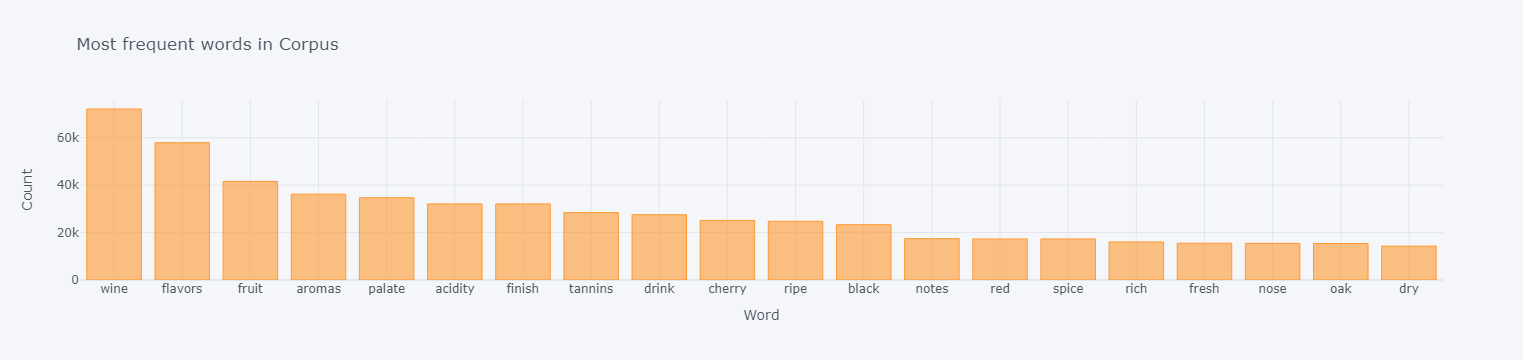

In [62]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

#### Prepare textual data only for Test

In [63]:
test_df, train_df = train_test_split(wine_reviews_desc, test_size=0.8, random_state=42)
train_df.shape, test_df.shape

((95940, 9), (23984, 9))

In [64]:
print(words_df.sort_values(by="wordImportance", ascending=False).head())
words_df.sample(5)

      word  wordCount  wordImportance  wordImportanceRelative
0     wine      72115        1.618634                1.000000
1  flavors      57911        1.299823                0.803037
2    fruit      41562        0.932866                0.576329
3   aromas      36203        0.812583                0.502018
4   palate      34700        0.778848                0.481176


,word,wordCount,wordImportance,wordImportanceRelative
42306,developing—,1,0.000022,0.000014
22991,cálem,2,0.000045,0.000028
5541,bells,24,0.000539,0.000333
43620,torreforte,1,0.000022,0.000014
38029,many—firm,1,0.000022,0.000014


In [65]:
k = 5
print(words_df[words_df.wordCount <=k].shape)
print(words_df[words_df.wordCount >k].shape)
most_pop_words_df = words_df[words_df.wordCount >k]
most_pop_words_df.shape

(32774, 4)
(11779, 4)


(11779, 4)

In [66]:
clean_vocab = set(most_pop_words_df.word)

In [67]:
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)
train_bow_counts = count_vect.fit_transform(train_df.description_pure)
test_bow_counts = count_vect.transform(test_df.description_pure)
train_bow_counts.shape, test_bow_counts.shape

C:\Users\olgas\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



((95940, 11779), (23984, 11779))

In [68]:
tf_idf_vectorizer = TfidfVectorizer(vocabulary = clean_vocab)
train_bow_tfidf = tf_idf_vectorizer.fit_transform(train_df.description_pure)
test_bow_tfidf = tf_idf_vectorizer.transform(test_df.description_pure)
train_bow_tfidf.shape, test_bow_tfidf.shape

((95940, 11779), (23984, 11779))

## Text Classification

In [70]:
%%capture

UsageError: %%capture is a cell magic, but the cell body is empty.


In [71]:
from sklearn.metrics import mean_squared_error, r2_score

In [72]:
model1 = Ridge(alpha=10)
reg = model1.fit(X=train_bow_tfidf, y=train_df.points)
#reg.score(train_bow_tfidf, train_df.points)

In [73]:
predicted_points = reg.predict(test_bow_tfidf)

In [74]:
reg.score(test_bow_tfidf, test_df.points)

0.6441387270354486

In [75]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(test_df.points, predicted_points))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(test_df.points, predicted_points))

Mean squared error: 3.43
Coefficient of determination: 0.64


In [76]:
points_predicted = reg.predict(test_bow_tfidf)
print("Mean squared error: %.2f" % mean_squared_error(test_df.points, points_predicted))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(test_df.points, points_predicted))
predicted_df = DataFrame()
predicted_df["actual"] = test_df.points
predicted_df["predicted"] = points_predicted

Mean squared error: 3.43
Coefficient of determination: 0.64


In [77]:
import plotly_express as px

rev_dict = {v:k for k,v in count_vect.vocabulary_.items()}
weights = model1.coef_.flatten()
words = [rev_dict[i] for i in range(len(weights))]
feature_weights = DataFrame({'word': words, 'weight': weights, 'absW': abs(weights)})
feature_weights.sort_values(by = 'absW', ascending = False, inplace = True)
feature_weights.head(10)

,word,weight,absW
773,beautiful,6.566269,6.566269
4457,gorgeous,6.185152,6.185152
2148,complex,5.660295,5.660295
774,beautifully,5.655558,5.655558
8860,sample,5.471939,5.471939
5898,long,5.318465,5.318465
5081,impressive,5.298521,5.298521
10101,superb,5.265397,5.265397
5524,lacks,-5.243830,5.243830
9316,simple,-5.131949,5.131949


In [79]:
points_predicted = reg.predict(test_bow_counts)
train_point_predicted = reg.predict(train_bow_counts)
mean_test = mean_squared_error(test_df.points, points_predicted)
mean_train = mean_squared_error(train_df.points, train_point_predicted)
r2_test = r2_score(test_df.points, points_predicted)
r2_train = r2_score(train_df.points, train_point_predicted)

print("Mean squared error: %.2f" % mean_squared_error(test_df.points, points_predicted))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(test_df.points, points_predicted))
print("Coefficient of training: %.2f" % r2_score(train_df.points, train_point_predicted))
print(test_df.shape)

print(points_predicted.shape)

Mean squared error: 3.01
Coefficient of determination: 0.69
Coefficient of training: 0.74
(23984, 9)
(23984,)


In [78]:
model2 = Ridge(alpha=10)
reg = model2.fit(X=train_bow_counts, y=train_df.points)
reg.score(train_bow_counts, train_df.points)

0.7372889530424097

In [82]:
results_df = results_df.append({'name':"description only, popular words", 'classifier':"Ridge", 'alpha': 10, 'reduction':"None", 'test_r2': r2_test, 'test_mse':mean_test, 'train_r2': r2_train, "train_mse": mean_train}, ignore_index=True)


C:\Users\olgas\AppData\Local\Temp\ipykernel_19968\3025983835.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [81]:
#results_df = append_to_results("description only, popular words","Ridge", "10", "None", test_df.points, points_predicted, train_df.points, train_point_predicted)
#results_df.at[4, 'test_r2'] = 0.69

ValueError: Found input variables with inconsistent numbers of samples: [23984, 23985]

In [83]:
results_df

,name,classifier,alpha,reduction,train_r2,train_mse,test_r2,test_mse
0,all categories and price,Ridge,10,None,0.305234,6.647890,"(0.30081382552241454,)",6.688209
1,partial categories and price,Ridge,1,None,0.294004,6.755348,"(0.2935037872691477,)",6.758134
2,all categories price with log,Ridge,10,None,0.439686,5.361382,"(0.4265526223611692,)",5.485428
3,all categories price limited price with log,Ridge,10,None,0.439272,5.365345,"(0.4262236339612465,)",5.488575
4,"description only, popular words",Ridge,10,None,0.737289,2.508716,0.68829,3.005307


### Full Pipeline

In [198]:
x = reviews.drop(columns={'points'})
y = reviews['points']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(X_train.shape), print(X_train.columns)
print(y_train.shape)
print(X_test.shape, y_test.shape)
print(X_test.columns)

(95939, 8)
Index(['country', 'description', 'price', 'province', 'taster_name', 'variety',
       'year', 'description_pure'],
      dtype='object')
(95939,)
(23985, 8) (23985,)
Index(['country', 'description', 'price', 'province', 'taster_name', 'variety',
       'year', 'description_pure'],
      dtype='object')


In [85]:
from sklearn.preprocessing import FunctionTransformer
text_features = ['description']

categorical_features = ['country', 'province','taster_name','variety']
numerical_features = ['price']

# Create categorical and numerical transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

text_transformer = Pipeline(steps=[
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    #("vect", CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)),
    ("tfidf", TfidfVectorizer(vocabulary=clean_vocab)),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# Combine transformers using ColumnTransformer
wine_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('txt', text_transformer, text_features)
], remainder='drop')

In [86]:
X_train.columns

Index(['country', 'description', 'price', 'province', 'taster_name', 'variety',
       'year', 'description_pure'],
      dtype='object')

In [87]:
params = text_transformer.get_params()
tfidf_params = params["tfidf"].get_params()

In [199]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# Create a full pipeline with a classifier with text
full_pipeline = Pipeline(steps=[
    ('preprocessor', wine_preprocessor),
    ('classifier', Ridge(alpha=10.0))
])
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country', 'pr...
                                                                                               'ably',
                                                                                               'abound',
                                                                                               'abounds',
                                                                                               'abouriou',
                                                                                               'aboveaverage',
                                                                                               'abrasive',
                                                                                               'abrupt',
                                                                                               'abruptly',
                                                                                               'abruzzo',
                                                                                               'absence',
                                                                                               'absolute',
                                                                                               'absolutely',
                                                                                               'absorb',
                                                                                               'absorbed',
                                                                                               'abundance',
                                                                                               'abundant',
                                                                                               'abundantly',
                                                                                               'abv',
                                                                                               'acacia',
                                                                                               'acai',
                                                                                               'acase', ...})),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001EBDAD97B80>))]),
                                                  ['description'])])),
                ('classifier', Ridge(alpha=10.0))])

In [89]:
print(X_train.iloc[2])
print(y_train[0:10])
X_train[0:10]
#print(X_train.head(2))


country                                                                                                                                                                                                                                                                                                     Chile
description         A potent, dark style of Syrah, with aromas of black cherry, generous oak, leather and vanilla. Shows overdrive on the palate, with forceful tannins and concentrated flavors of blackberry, graphite, black licorice and wood resin. Fruity and long on the back end; drink now through 2013.
price                                                                                                                                                                                                                                                                                                    1.061385
province                                                                          

,country,description,price,province,taster_name,variety,year,description_pure
125300,US,"Winemaker Gustavo Gonzalez left Robert Mondavi to do his own thing, and what an auspicious start. He's taken fruit from this historic Carneros vineyard and crafted a big and bold yet balanced Pinot filled with lusciousness. The flavors are enormously complex, ranging from fresh raspberry jam and...",1.318462,California,NaN,Pinot Noir,2010.0,Winemaker Gustavo Gonzalez left Robert Mondavi to do his own thing and what an auspicious start Hes taken fruit from this historic Carneros vineyard and crafted a big and bold yet balanced Pinot filled with lusciousness The flavors are enormously complex ranging from fresh raspberry jam and ...
110511,Spain,"This is the granddaddy in the Emilio Moro portfolio, but the wine is so ripe and oaky it's syrupy-smelling. Maximum ripeness means it's a bit Port-like on the palate, with baked black-fruit flavors that finish soft and jammy. This brims with power, extraction and flavor but it's grasping for str...",1.809804,Northern Spain,Michael Schachner,Tinto Fino,2010.0,This is the granddaddy in the Emilio Moro portfolio but the wine is so ripe and oaky its syrupysmelling Maximum ripeness means its a bit Portlike on the palate with baked blackfruit flavors that finish soft and jammy This brims with power extraction and flavor but its grasping for structure...
87721,Chile,"A potent, dark style of Syrah, with aromas of black cherry, generous oak, leather and vanilla. Shows overdrive on the palate, with forceful tannins and concentrated flavors of blackberry, graphite, black licorice and wood resin. Fruity and long on the back end; drink now through 2013.",1.061385,Maule Valley,Michael Schachner,Syrah,2009.0,A potent dark style of Syrah with aromas of black cherry generous oak leather and vanilla Shows overdrive on the palate with forceful tannins and concentrated flavors of blackberry graphite black licorice and wood resin Fruity and long on the back end drink now through
19638,Spain,"Cloudy in color, with tart rhubarb aromas. The palate shows some acidity and tang, with pink grapefruit flavors offering a shrill kick. But overall the wine has seen better days and has become limited in scope at this point.",0.874591,Central Spain,Michael Schachner,Tempranillo,2006.0,Cloudy in color with tart rhubarb aromas The palate shows some acidity and tang with pink grapefruit flavors offering a shrill kick But overall the wine has seen better days and has become limited in scope at this point
8950,Italy,"There's a ripe and opulent quality that gives the wine loads of intensity and consistency. The purity of the fruit is excellent, and the finish reveals nicely integrated acidity.",1.128508,Sicily & Sardinia,NaN,Nero d'Avola,2010.0,Theres a ripe and opulent quality that gives the wine loads of intensity and consistency The purity of the fruit is excellent and the finish reveals nicely integrated acidity
127062,France,"Don't be fooled by this wine. Although it looks like a typical dry Provence rosé, it's medium sweet. With Black Muscat in the blend, it's soft and perfumed, its sweetness balanced by acidity.",0.910235,France Other,Roger Voss,Rosé,2016.0,Dont be fooled by this wine Although it looks like a typical dry Provence rosé its medium sweet With Black Muscat in the blend its soft and perfumed its sweetness balanced by acidity
79641,US,"Concentrated fruit, spice and black-tea flavors lend a sense of depth on the palate and make this full-bodied wine satisfying to sip. Made from the estate vineyard using only Clone 777 vines, it matches black cherry and tart cherry notes to a nicely gripping texture, with a lingering finish.",1.432618,California,Jim Gordon,Pinot Noir,2014.0,Concentrated fruit spice and blacktea flavors lend a sense of depth on the palate and make this fullbodied wine satisfying to sip Made from the estate vineyard using only Clone vines it matches black cherry and tart cherry notes to a nicely gripping tex

In [200]:
# Fit the pipeline to the training data
full_pipeline.fit(X_train, y_train)

# Evaluate the pipeline on the test data
#accuracy = full_pipeline.score(X_test, y_test)
#print(f"Test accuracy: {accuracy:.3f}")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country', 'pr...
                                                                                               'ably',
                                                                                               'abound',
                                                                                               'abounds',
                                                                                               'abouriou',
                                                                                               'aboveaverage',
                                                                                               'abrasive',
                                                                                               'abrupt',
                                                                                               'abruptly',
                                                                                               'abruzzo',
                                                                                               'absence',
                                                                                               'absolute',
                                                                                               'absolutely',
                                                                                               'absorb',
                                                                                               'absorbed',
                                                                                               'abundance',
                                                                                               'abundant',
                                                                                               'abundantly',
                                                                                               'abv',
                                                                                               'acacia',
                                                                                               'acai',
                                                                                               'acase', ...})),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001EBDAD97B80>))]),
                                                  ['description'])])),
                ('classifier', Ridge(alpha=10.0))])

In [91]:
#score of training
full_pipeline.score(X_train, y_train)

0.7517024082740298

In [203]:
#score of test

test_predict = full_pipeline.predict(X_test)
train_predict = full_pipeline.predict(X_train)
test_r2 = r2_score(y_test,test_predict)
trin_r2 = r2_score(y_train,train_predict)
test_mse = mean_squared_error(y_test, test_predict)
train_mse = mean_squared_error(y_train, train_predict)

In [208]:
results_df = append_row_to_results("full pipeline, price with no log ","Ridge", "10", "None", test_r2, test_mse, trin_r2, train_mse )

C:\Users\olgas\AppData\Local\Temp\ipykernel_19968\2814298460.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [209]:
results_df# = results_df.drop(0)

,name,classifier,alpha,reduction,train_r2,train_mse,test_r2,test_mse
0,"full pipeline, price with no log",Ridge,10,None,0.751702,2.375844,0.729254,2.58988


In [106]:
test_predict_actual = DataFrame(zip(test_predict, y_test, X_test.description, X_test.province, X_test.taster_name, X_test.country, X_test.variety), columns=['predict', 'actual', 'description', 'province', 'tester_name', 'country', 'variety'])

In [97]:
test_predict_actual['abs_error'] = abs(test_predict_actual.predict - test_predict_actual.actual)
#test_predict_actual.sort_values(by=['abs_error'], ascending=False).head(50)

In [98]:
sum(abs(test_predict_actual.predict - test_predict_actual.actual))/len(test_predict_actual)

1.2674571077547225

In [99]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(test_predict_actual.actual, test_predict_actual.predict))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(test_predict_actual.actual, test_predict_actual.predict))

Mean squared error: 2.59
Coefficient of determination: 0.73


#### GridSearch to find most efficient apha and classifier

In [100]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

# Create a full pipeline with a classifier with text
pipeline_no_classifier = Pipeline(steps=[
    ('preprocessor', wine_preprocessor),
    #('dimension_reduction', 'passthrogh'),
    ('classifier', Ridge())
])
pipeline_no_classifier

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['price']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country', 'pr...
                                                                                               'able',
                                                                                               'ably',
                                                                                               'abound',
                                                                                               'abounds',
                                                                                               'abouriou',
                                                                                               'aboveaverage',
                                                                                               'abrasive',
                                                                                               'abrupt',
                                                                                               'abruptly',
                                                                                               'abruzzo',
                                                                                               'absence',
                                                                                               'absolute',
                                                                                               'absolutely',
                                                                                               'absorb',
                                                                                               'absorbed',
                                                                                               'abundance',
                                                                                               'abundant',
                                                                                               'abundantly',
                                                                                               'abv',
                                                                                               'acacia',
                                                                                               'acai',
                                                                                               'acase', ...})),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001EBDAD97B80>))]),
                                                  ['description'])])),
                ('classifier', Ridge())])

In [131]:
param_grid = [   
    {
        'preprocessor__txt__tfidf__max_features': [500, None],
        'classifier__alpha': [1, 10],
    }
]

In [132]:
from sklearn.model_selection import GridSearchCV
full_pipeline_grid_search = GridSearchCV(pipeline_no_classifier, param_grid = param_grid, cv=3, scoring='r2', verbose=5)
full_pipeline_grid_search

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_out...
                                                                                                                      'absolute',
                                                                                                                      'absolutely',
                                                                                                                      'absorb',
                                                                                                                      'absorbed',
                                                                                                                      'abundance',
                                                                                                                      'abundant',
                                                                                                                      'abundantly',
                                                                                                                      'abv',
                                                                                                                      'acacia',
                                                                                                                      'acai',
                                                                                                                      'acase', ...})),
                                                                                         ('toarray',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001EBDAD97B80>))]),
                                                                         ['description'])])),
                                       ('classifier', Ridge())]),
             param_grid=[{'classifier__alpha': [1, 10],
                          'preprocessor__txt__tfidf__max_features': [500,
                                                                     None]}],
             scoring='r2', verbose=5)

In [211]:
x = reviews.drop(columns={'points'})
x['price'] = np.log(x['price'])
y = reviews['points']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [134]:
full_pipeline_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END classifier__alpha=1, preprocessor__txt__tfidf__max_features=500;, score=0.750 total time= 4.6min
[CV 2/3] END classifier__alpha=1, preprocessor__txt__tfidf__max_features=500;, score=0.746 total time= 4.3min
[CV 3/3] END classifier__alpha=1, preprocessor__txt__tfidf__max_features=500;, score=0.751 total time= 4.2min
[CV 1/3] END classifier__alpha=1, preprocessor__txt__tfidf__max_features=None;, score=0.750 total time= 4.2min
[CV 2/3] END classifier__alpha=1, preprocessor__txt__tfidf__max_features=None;, score=0.746 total time= 4.2min
[CV 3/3] END classifier__alpha=1, preprocessor__txt__tfidf__max_features=None;, score=0.751 total time= 4.2min
[CV 1/3] END classifier__alpha=10, preprocessor__txt__tfidf__max_features=500;, score=0.720 total time= 4.3min
[CV 2/3] END classifier__alpha=10, preprocessor__txt__tfidf__max_features=500;, score=0.717 total time= 4.2min
[CV 3/3] END classifier__alpha=10, preprocessor__txt__t

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_out...
                                                                                                                      'absolute',
                                                                                                                      'absolutely',
                                                                                                                      'absorb',
                                                                                                                      'absorbed',
                                                                                                                      'abundance',
                                                                                                                      'abundant',
                                                                                                                      'abundantly',
                                                                                                                      'abv',
                                                                                                                      'acacia',
                                                                                                                      'acai',
                                                                                                                      'acase', ...})),
                                                                                         ('toarray',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001EBDAD97B80>))]),
                                                                         ['description'])])),
                                       ('classifier', Ridge())]),
             param_grid=[{'classifier__alpha': [1, 10],
                          'preprocessor__txt__tfidf__max_features': [500,
                                                                     None]}],
             scoring='r2', verbose=5)

In [135]:
cols = ['param_classifier__alpha','param_preprocessor__txt__tfidf__max_features', 'std_test_score', 'rank_test_score', 'mean_test_score', ]
cv_results_df = pd.DataFrame(full_pipeline_grid_search.cv_results_)
cv_results_df.sort_values(by = 'mean_test_score', ascending=False)[cols]

,param_classifier__alpha,param_preprocessor__txt__tfidf__max_features,std_test_score,rank_test_score,mean_test_score
0,1,500,0.002138,1,0.748746
1,1,None,0.002138,1,0.748746
2,10,500,0.002251,3,0.719639
3,10,None,0.002251,3,0.719639


In [158]:
y_actual = full_pipeline_grid_search.predict(X_test)

In [163]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_actual))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_actual))
predicted_df1 = DataFrame()
predicted_df1["actual"] = y_test
predicted_df1["predicted"] = y_actual
predicted_df1["price"] = X_test.price
predicted_df1["error"] = abs(y_test - y_actual)
predicted_df1.sort_values(by="error", ascending=False).head(10)


Mean squared error: 2.37
Coefficient of determination: 0.75


,actual,predicted,price,error
23427,81,88.768537,0.092751,7.768537
21837,80,87.302616,0.202228,7.302616
75552,82,89.253543,0.310462,7.253543
48895,98,90.810452,NaN,7.189548
52635,95,88.001956,0.176186,6.998044
10745,95,88.202281,NaN,6.797719
82750,99,92.293335,0.529995,6.706665
121133,83,89.597513,0.380266,6.597513
91691,81,87.516967,0.040577,6.516967
109427,99,92.601747,0.554534,6.398253


In [215]:
test_predict = full_pipeline_grid_search.predict(X_test)
train_predict = full_pipeline_grid_search.predict(X_train)

In [216]:
test_r2_1 = r2_score(y_test,test_predict )
trin_r2_1 = r2_score(y_train,train_predict)
test_mse_1 = mean_squared_error(y_test, test_predict)
train_mse_1 = mean_squared_error(y_train, train_predict)

In [218]:
results_df = results_df.drop(1)
results_df

,name,classifier,alpha,reduction,train_r2,train_mse,test_r2,test_mse
0,"full pipeline, price with no log",Ridge,10,None,0.751702,2.375844,0.729254,2.589880
1,"full pipeline, price with log",Ridge,1,500,0.793290,1.977914,0.752595,2.366602


In [219]:
results_df = append_row_to_results("full pipeline, price with  log ","Ridge", full_pipeline_grid_search.best_params_['classifier__alpha'], full_pipeline_grid_search.best_params_['preprocessor__txt__tfidf__max_features'], test_r2_1, test_mse_1, trin_r2_1, train_mse_1 )

C:\Users\olgas\AppData\Local\Temp\ipykernel_19968\2814298460.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [148]:
print(full_pipeline.score(X_test, y_test))

-2.9817163021408897


In [ ]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', wine_preprocessor),
    #('dimension_reduction', 'passthrogh'),
    ('classifier', Ridge(alpha=1))
])
full_pipeline.

In [221]:
results_df

,name,classifier,alpha,reduction,train_r2,train_mse,test_r2,test_mse
0,"full pipeline, price with no log",Ridge,10,None,0.751702,2.375844,0.729254,2.589880
1,"full pipeline, price with log",Ridge,1,500,0.793290,1.977914,0.752595,2.366602


In [164]:
train_predict = full_pipeline_grid_search.predict(X_train)
results_df = append_to_results("full pipeline, price with log ","Ridge", full_pipeline_grid_search.best_params_['classifier__alpha'], full_pipeline_grid_search.best_params_['preprocessor__txt__tfidf__max_features'],y_actual,  y_test, train_predict,  y_train)

C:\Users\olgas\AppData\Local\Temp\ipykernel_19968\16745098.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [167]:
results_df = results_df.drop(index=5)

In [ ]:
full_pipeline2 = Pipeline(steps=[
    ('preprocessor', wine_preprocessor),
    ('param_reduction', PCA()),
    ('classifier', Ridge()),
    
])


param_grid2 = [
    {        
        'param_reduction__n_components': [500, 2000, 10000],
        'classifier__alpha': [0.01, 0.1, 0.5],
    }
]

In [ ]:
from sklearn.model_selection import GridSearchCV
full_pipeline_grid_search2 = GridSearchCV(full_pipeline2, param_grid = param_grid2, cv=3, scoring='r2', verbose=5)
full_pipeline_grid_search2

In [ ]:
full_pipeline_grid_search2.fit(X_train, y_train)

In [ ]:
full_pipeline_grid_search2.best_params_

In [ ]:
full_pipeline.score(X_test, y_test)
test_predict = full_pipeline.predict(X_test)
train_predict = full_pipeline.predict(X_train)
#results_df = append_to_results("full pipeline, price with no log ","Ridge", "10", "None", y_test, test_predict, y_train, train_predict)